In [74]:
from load_dataset import TimeSeries
from matplotlib import pyplot as plt

In [75]:
import sys
sys.path.append('/home/dxie/myPy/VEBTF')
sys.path.append('/home/dxie/myPy/VEBTF/src')
from src.vebtf import VEBTF


In [510]:

import numpy as np
from skimage.restoration import denoise_wavelet, estimate_sigma
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

class wavelet_denoise:
    def __init__(self, wavelet='haar', mode='soft', wavelet_levels=None, method='VisuShrink',num_shifts=1,sigma=None):
        self.wavelet = wavelet
        self.mode = mode
        self.wavelet_levels = wavelet_levels
        self.method = method
        self.num_shifts = num_shifts
        self.sigma = sigma

    def fit(self, y):
        """
        Apply translation-invariant wavelet denoising to an y.
        
        Parameters:
        - y: The input y to be denoised.
        - sigma, wavelet, mode, wavelet_levels, convert2ycbcr, method: Parameters for the denoise_wavelet function.
        - num_shifts: Number of shifts for cycle spinning.
        
        Returns:
        - Denoised y with translation-invariant wavelet denoising.
        """
        # mirror the y
        n = len(y)
        y = np.concatenate([y, y[::-1]])
        denoised_y = np.zeros_like(y)
        self.num_shifts = min(self.num_shifts, y.shape[0] - 1)
        shifts = np.linspace(0, y.shape[0] - 1, num=self.num_shifts, dtype=int)
        if self.sigma is None:
            self.sigma = estimate_sigma(y)
        for shift in shifts:
            # Shift the y
            shifted_y = np.roll(y, shift, axis=0)

            # Denoise the shifted y
            denoised_shifted_y = denoise_wavelet(shifted_y, sigma=self.sigma, wavelet=self.wavelet,
                                                    mode=self.mode, wavelet_levels=self.wavelet_levels,method=self.method)

            # Shift back and accumulate the result
            denoised_y += np.roll(denoised_shifted_y, -shift, axis=0)

        # Average the accumulated denoised ys
        denoised_y /= self.num_shifts
        self.mu = denoised_y[0:n]
        #return denoised_y[0:n]


class genlasso_tf:
    def __init__(self,ord=0,k=5):
        self.ord = ord
        self.k = k

    def fit(self, y):
        """
        Apply trend filtering to a given array y with specified order ord.

        Parameters:
        - y: NumPy array containing the input data.
        - ord: Order of the trend filter (0 for piecewise constant, 1 for piecewise linear, etc.).

        Returns:
        - fit_tf: NumPy array containing the trend-filtered output.
        """
        numpy2ri.activate()
        genlasso = importr('genlasso')
        y_r = ro.FloatVector(y)
        fit_tf_r = genlasso.trendfilter(y_r, ord=self.ord)
        fit_tf_cv_r = genlasso.cv_trendfilter(fit_tf_r, k=self.k, verbose=False)
        fit_tf_coef_r = genlasso.coef_genlasso(fit_tf_r, fit_tf_cv_r.rx2('lambda.1se')) 
        fit_tf = np.array(fit_tf_coef_r.rx2('beta'))
        self.mu=fit_tf.squeeze()
        #return fit_tf.squeeze()


class susie_tf:
    def __init__(self,L=20):
        self.L = L

    def fit(self, y):
        """
        Apply trend filtering to a given array y with specified order ord.

        Parameters:
        - y: NumPy array containing the input data.
        - ord: Order of the trend filter (0 for piecewise constant, 1 for piecewise linear, etc.).

        Returns:
        - fit_tf: NumPy array containing the trend-filtered output.
        """
        numpy2ri.activate()
        susieR = importr('susieR')
        y_r = ro.FloatVector(y)
        fit_tf_r = susieR.susie_trendfilter(y_r,L=self.L)
        fit_tf = np.array(susieR.predict_susie(fit_tf_r))
        self.mu = fit_tf.squeeze()
        #return fit_tf.squeeze()



In [571]:
ts = TimeSeries.from_json('../../datasets/bee_waggle_6/bee_waggle_6.json')
ts.df


,t,x,y,sin(theta),cos(theta)
0,0,434.000000,300.000000,-0.768221,0.640184
1,1,435.689282,297.745135,-0.801398,0.598132
2,2,431.330160,290.737165,-0.629299,0.777163
3,3,443.249551,293.705045,-0.776353,0.630298
4,4,433.885970,286.124349,-0.487888,0.872906
...,...,...,...,...,...
604,604,460.422421,255.308738,-0.999249,0.038750
605,605,460.355204,255.057431,-0.984668,0.174438
606,606,455.472991,253.271702,-0.906891,0.421364
607,607,452.110165,252.567149,-0.780056,0.625710


In [572]:
genlasso = genlasso_tf(ord=0)
genlasso.fit(ts.df['sin(theta)'])

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


In [573]:
y = np.array(ts.df['sin(theta)'])
n = len(y)
model =  VEBTF(sigma2=1,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000,num_shift_wavelet=100,method_wavelet='VisuShrink')
model.fit(y,mu_init=genlasso.mu)
print(model.sigma2)

Iteration 0: ELBO = -1779.5611594283212
0.00946395315314052


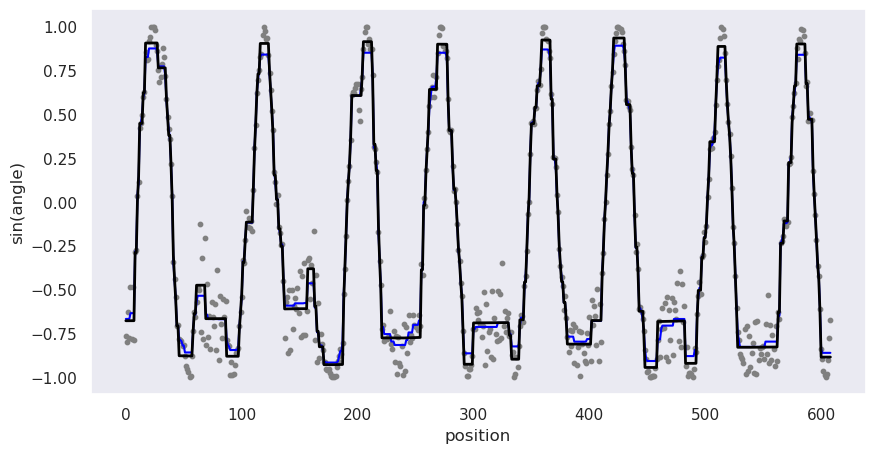

In [574]:
import seaborn as sns
# Set the style of the plot using Seaborn
sns.set(style="dark")
plt.figure(figsize=(10, 5))
plt.scatter(ts.df['t'], ts.df['sin(theta)'],color='grey',s=10)
plt.plot(ts.df['t'],genlasso.mu,color='blue')
plt.plot(ts.df['t'],model.mu,color='black',linewidth=2)
plt.xlabel('position')
plt.ylabel('sin(angle)')
plt.savefig('bee.pdf', bbox_inches='tight')
plt.show()

In [254]:
ts = TimeSeries.from_json('../../datasets/co2_canada/co2_canada.json')
ts.df

,t,V1
0,0,0.00568
1,1,0.00561
2,2,0.00555
3,3,0.00548
4,4,0.00542
...,...,...
210,210,15.60000
211,211,15.60000
212,212,14.80000
213,213,14.70000


In [255]:
y = ts.df['V1']
genlasso = genlasso_tf(ord=0)
genlasso.fit(y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


Iteration 0: ELBO = -698.5390337378385
0.04110635170158694


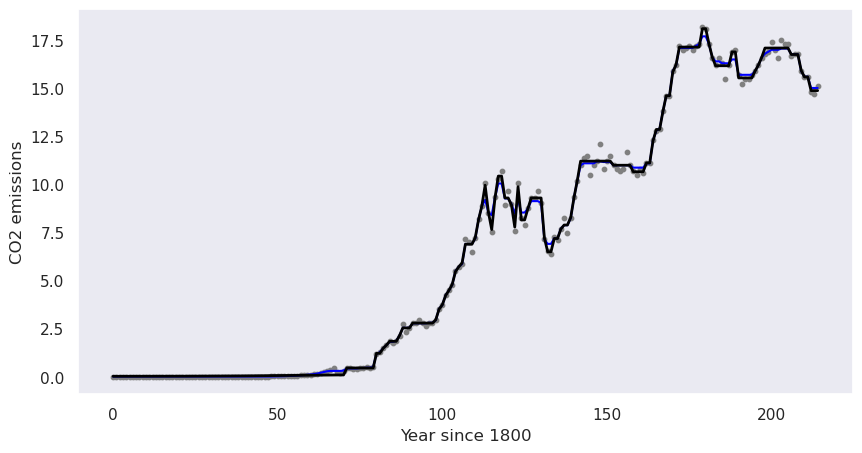

In [264]:
y = np.array(y)
n = len(y)
model =  VEBTF(sigma2=1,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000,num_shift_wavelet=1,method_wavelet='VisuShrink')
model.fit(y,mu_init=genlasso.mu)
print(model.sigma2)
plt.figure(figsize=(10, 5))
plt.scatter(ts.df['t'], y,color='grey',s=10)
plt.plot(ts.df['t'],genlasso.mu,color='blue')
plt.plot(ts.df['t'],model.mu,color='black',linewidth=2)
plt.xlabel('Year since 1800')
plt.ylabel('CO2 emissions')
plt.savefig('co2.pdf', bbox_inches='tight')
plt.show()

In [575]:
ts = TimeSeries.from_json('../../datasets/homeruns/homeruns.json')
ts.df

,t,American League Home Runs
0,0,228.0
1,1,258.0
2,2,184.0
3,3,156.0
4,4,156.0
...,...,...
113,113,2161.0
114,114,2634.0
115,115,2953.0
116,116,3170.0


In [576]:
y = ts.df['American League Home Runs']
genlasso = genlasso_tf(ord=0)
genlasso.fit(y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


Iteration 0: ELBO = -1007.1150243099978
27831.68858051534


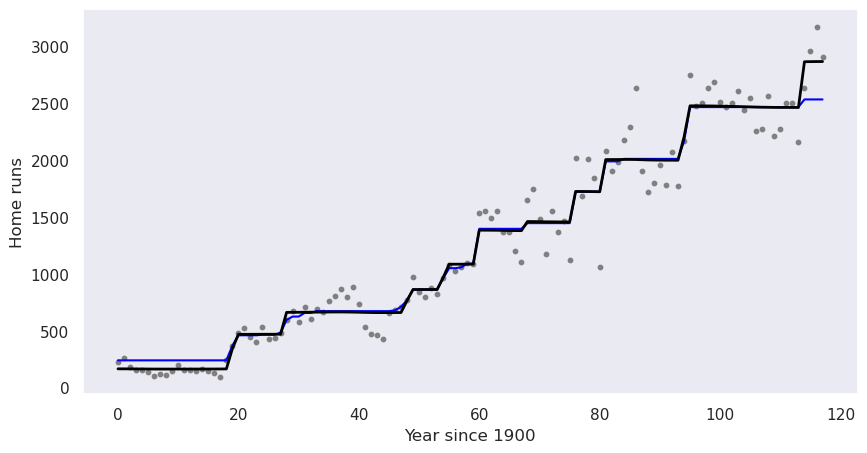

In [596]:
y = np.array(y)
n = len(y)
model =  VEBTF(sigma2=50000,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000,num_shift_wavelet=10,method_wavelet='VisuShrink')
model.fit(y,mu_init=genlasso.mu)
print(model.sigma2)
plt.figure(figsize=(10, 5))
plt.scatter(ts.df['t'], y,color='grey',s=10)
plt.plot(ts.df['t'],genlasso.mu,color='blue')
plt.plot(ts.df['t'],model.mu,color='black',linewidth=2)
plt.xlabel('Year since 1900')
plt.ylabel('Home runs')
#plt.savefig('homeruns.pdf', bbox_inches='tight')
plt.show()

In [597]:
ts = TimeSeries.from_json('../../datasets/nile/nile.json')
ts.df

,t,Volume at Aswan
0,0,1120.0
1,1,1160.0
2,2,963.0
3,3,1210.0
4,4,1160.0
...,...,...
95,95,746.0
96,96,919.0
97,97,718.0
98,98,714.0


In [598]:
y = ts.df['Volume at Aswan']
genlasso = genlasso_tf(ord=0)
genlasso.fit(y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


Iteration 0: ELBO = -810.8621264401797


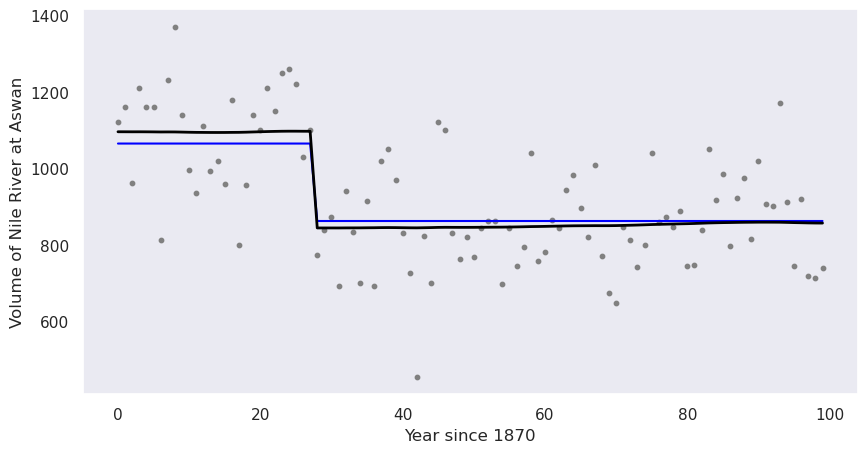

In [603]:
y = np.array(y)
n = len(y)
model =  VEBTF(sigma2=1e5,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/3,maxiter=1000,num_shift_wavelet=n,method_wavelet='VisuShrink')
model.fit(y,mu_init='wavelet')
plt.figure(figsize=(10, 5))
plt.scatter(ts.df['t'], y,color='grey',s=10)
plt.plot(ts.df['t'],genlasso.mu,color='blue')
plt.plot(ts.df['t'],model.mu,color='black',linewidth=2)
plt.xlabel('Year since 1870')
plt.ylabel('Volume of Nile River at Aswan')
plt.savefig('nile.pdf', bbox_inches='tight')
plt.show()

In [318]:
ts = TimeSeries.from_json('../../datasets/rail_lines/rail_lines.json')
ts.df

,t,V1
0,0,1.000507e+06
1,1,9.961533e+05
2,2,9.949100e+05
3,3,9.920928e+05
4,4,9.833025e+05
5,5,9.753426e+05
6,6,9.638781e+05
7,7,9.493885e+05
8,8,9.418089e+05
9,9,9.386643e+05


In [319]:
y = ts.df['V1']
genlasso = genlasso_tf(ord=0)
genlasso.fit(y)

Fold 1 ... 

Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


Iteration 0: ELBO = -454.4276897769649
34613122.72966486


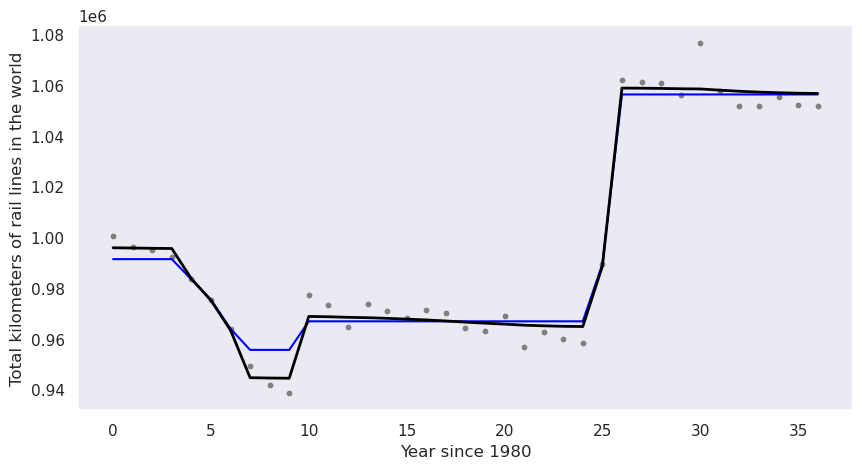

In [366]:
y = np.array(y)
n = len(y)
model =  VEBTF(sigma2=4e7,fix_sigma2=False,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n),maxiter=1000,num_shift_wavelet=30,method_wavelet='VisuShrink')
model.fit(y,mu_init='wavelet')
print(model.sigma2)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y)), y,color='grey',s=10)
plt.plot(range(len(y)),genlasso.mu,color='blue')
plt.plot(range(len(y)),model.mu,color='black',linewidth=2)
plt.xlabel('Year since 1980')
plt.ylabel('Total kilometers of rail lines in the world')
plt.savefig('rail_lines.pdf', bbox_inches='tight')
plt.show()

In [367]:
ts = TimeSeries.from_json('../../datasets/robocalls/robocalls.json')
ts.df

,t,V1
0,0,1.638406e+09
1,1,1.301469e+09
2,2,9.390090e+08
3,3,8.778650e+08
4,4,8.312185e+08
5,5,6.829055e+08
6,6,9.807400e+08
7,7,1.456482e+09
8,8,2.253169e+09
9,9,2.278604e+09


In [377]:
ts.datestr

array(['2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10',
       '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04',
       '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10',
       '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10',
       '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04',
       '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10',
       '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04',
       '2019-05', '2019-06', '2019-07', '2019-08'], dtype='<U7')

In [369]:
y = ts.df['V1']
genlasso = genlasso_tf(ord=0)
genlasso.fit(y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


Iteration 0: ELBO = -1185.1637713474286
2.5719479667309788e+16


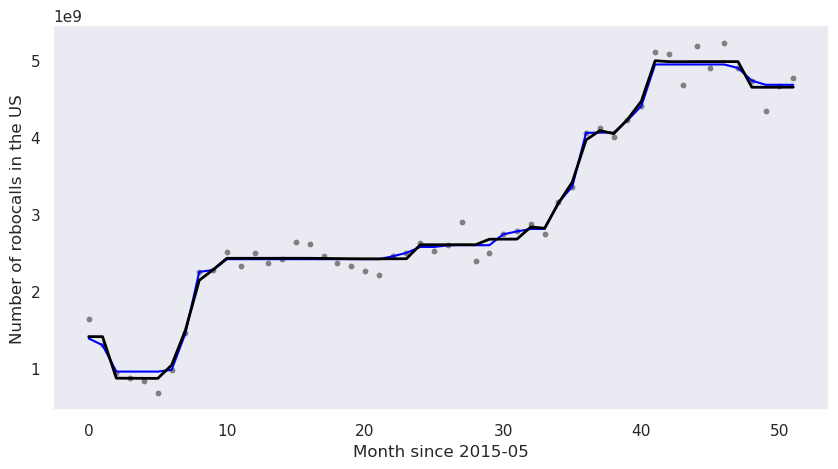

In [379]:
y = np.array(y)
n = len(y)
model =  VEBTF(sigma2=2e16,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000,num_shift_wavelet=10,method_wavelet='VisuShrink')
model.fit(y,mu_init='wavelet')
print(model.sigma2)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y)), y,color='grey',s=10)
plt.plot(range(len(y)),genlasso.mu,color='blue')
plt.plot(range(len(y)),model.mu,color='black',linewidth=2)
plt.xlabel('Month since 2015-05')
plt.ylabel('Number of robocalls in the US')
plt.savefig('robocalls.pdf', bbox_inches='tight')
plt.show()

In [397]:
ts = TimeSeries.from_json('../../datasets/shanghai_license/shanghai_license.json')
ts.df

,t,No. of Applicants
0,0,3718.0
1,1,4590.0
2,2,5190.0
3,3,4806.0
4,4,4665.0
...,...,...
200,200,189142.0
201,201,181861.0
202,202,177355.0
203,203,165442.0


In [408]:
y = ts.df['No. of Applicants']
y = y.drop([58,74])
genlasso = genlasso_tf(ord=0)
genlasso.fit(y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


Iteration 0: ELBO = -2446.500111249002
8112999.418839111


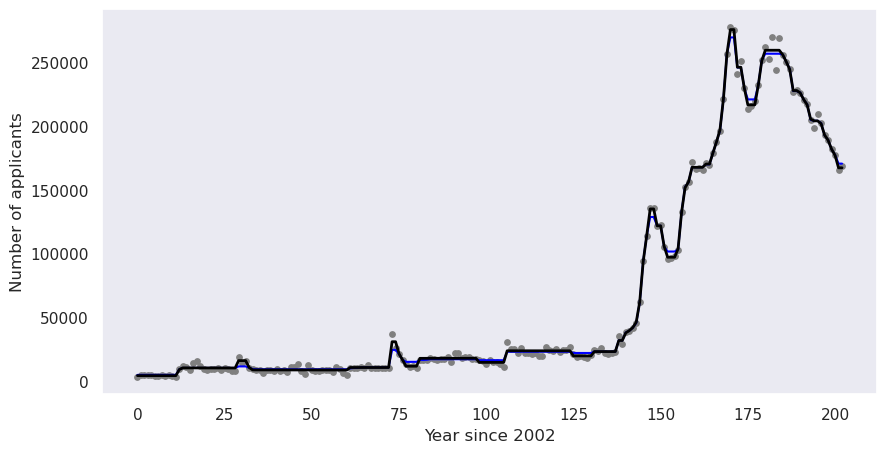

In [423]:
y = np.array(y)
n = len(y)
model =  VEBTF(sigma2=1e7,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000,num_shift_wavelet=1,method_wavelet='VisuShrink')
model.fit(y,mu_init=genlasso.mu)
print(model.sigma2)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y)), y,color='grey',s=15)
plt.plot(range(len(y)),genlasso.mu,color='blue')
plt.plot(range(len(y)),model.mu,color='black',linewidth=2)
plt.xlabel('Year since 2002')
plt.ylabel('Number of applicants')
plt.savefig('shanghai_license.pdf', bbox_inches='tight')
plt.show()

In [425]:
ts = TimeSeries.from_json('../../datasets/well_log/well_log.json')
ts.df

,t,V1
0,0,133530.60
1,1,121415.70
2,2,99749.55
3,3,102195.20
4,4,110237.30
...,...,...
670,670,111724.20
671,671,111714.00
672,672,108851.80
673,673,103871.40


Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


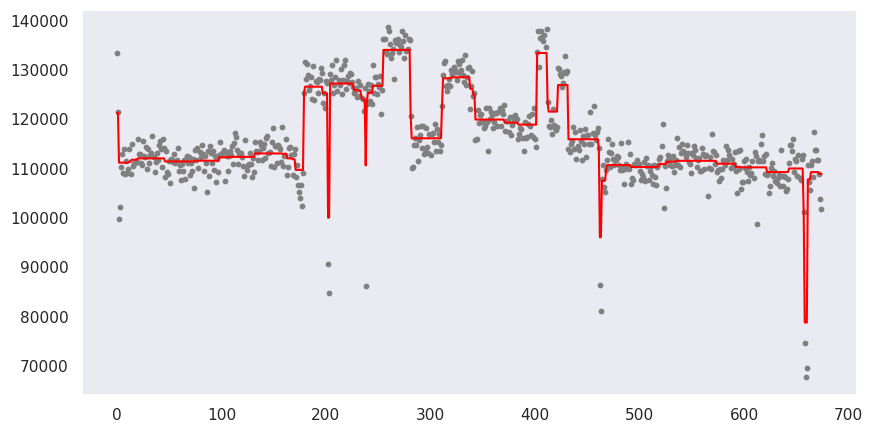

In [426]:
y = ts.df['V1']
genlasso = genlasso_tf(ord=0)
genlasso.fit(y)
plt.figure(figsize=(10, 5))
plt.scatter(ts.df['t'], y,color='grey',s=10)
plt.plot(ts.df['t'],genlasso.mu,color='red')
plt.show()

In [533]:
y = ts.df['V1']
y = y[y>102000]
y = y[10:]
genlasso = genlasso_tf(ord=0,k=5)
genlasso.fit(y)


Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


Iteration 0: ELBO = -7150.845649965422
5190793.37135383


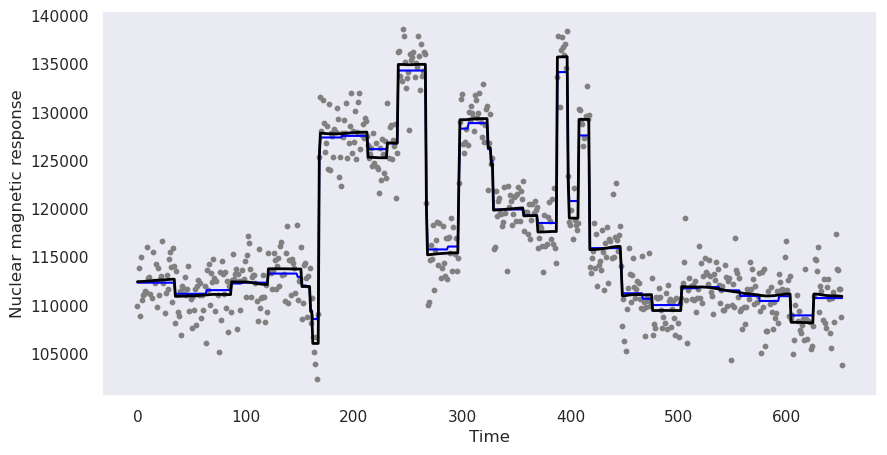

In [570]:
y = np.array(y)
n = len(y)
model =  VEBTF(sigma2=1e7,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/1,maxiter=1000,num_shift_wavelet=n,method_wavelet='VisuShrink')
model.fit(y,mu_init=genlasso.mu)
print(model.sigma2)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y)), y,color='grey',s=10)
plt.plot(range(len(y)),genlasso.mu,color='blue')
plt.plot(range(len(y)),model.mu,color='black',linewidth=2)
plt.xlabel('Time')
plt.ylabel('Nuclear magnetic response')
plt.savefig('well_log.pdf', bbox_inches='tight')
plt.show()